# Import

In [ ]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# DQN 

In [ ]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 16) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

        #init weights
        self.apply(self._init_weights)

    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)  # Example: Xavier initialization
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
            
    def forward(self, X):
        return self.model(X)

In [ ]:
# Test
dqn = DQN(4,2,16)

# Explore CartPole

In [ ]:
env = gym.make('CartPole-v1', render_mode = 'human')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Replay Memory

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state):
        self.memory.append(Transition(state, action, reward, next_state))
    
    def sample(self, batch_size):
        if batch_size > len(self.memory): return None
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [ ]:
#Test memory
memory = ReplayMemory(capacity=10)

for _ in range(10):
    state = random.randint(0,8)
    action = random.randint(0,3)
    reward = random.randint(-10, 10)
    next_state = random.randint(0,8)
    memory.push(state, action, reward, next_state)

batch = memory.sample(5)
print(batch)

# Greedy Epsilon Policy

In [ ]:
def select_action(state, epsilon, policy_net, env):
    p = random.random()
    #exploit
    # state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)
    assert torch.is_tensor(state), 'state in select action must be a tensor'
    if p > epsilon: 
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1)
    else:
        return torch.tensor([env.action_space.sample()], dtype = torch.long)

def epsilon_function(min_ep, max_ep, decay_ep, current_ep, total_eps, mode = 'linear'):
    return  max(min_ep, max_ep * decay_ep ** current_ep)

def plot_epsilon_decay(min_ep, max_ep, decay_ep, training_eps):
    eps = []
    for t in range(training_eps):
        eps.append(epsilon_function(min_ep, max_ep, decay_ep, t, training_eps))
    sns.lineplot(y = eps, x = list(range(len(eps))))

In [ ]:
#Test
# memory
memory = ReplayMemory(capacity=10)

env = gym.make('CartPole-v1', render_mode = 'human')
state, info = env.reset()

observation_n = len(state)
print('observation n = ', observation_n)
action_n = env.action_space.n
print('action n = ', action_n)

policy_net = DQN(observation_n, action_n)
target_net = DQN(observation_n, action_n)

for _ in range(100):
    state = torch.rand((1,observation_n))
    next_state = torch.rand((1,observation_n))
    reward = torch.randint(-10,10, (1,1))
    action = torch.randint(0,action_n, (1,1))

    memory.push(state, action, reward, next_state)

    state = next_state

print(len(memory.memory))
transitions = memory.sample(5)
print(transitions)

# optimizer = torch.optim.AdamW(policy_net.parameters(), lr = 0.001)
# criterion = nn.SmoothL1Loss()

# GAMMA = 0.9

# optimize(memory, 5, policy_net=policy_net, target_net=target_net, optimizer=optimizer, criterion=criterion, gamma=GAMMA, device = 'cpu')
env.close()



In [ ]:
plot_epsilon_decay(0.2, 1.0, 0.9991, 2000)

# Training

In [ ]:
env = gym.make('CartPole-v1')
obs, info = env.reset()

observation_n = len(obs)
action_n = env.action_space.n
print('observation space = ', observation_n)
print('action space = ', action_n)

policy_net = DQN(observation_n, action_n, hidden_size = 16)
target_net = DQN(observation_n, action_n, hidden_size = 16)

optimzer = torch.optim.Adam(policy_net.parameters(), lr = 5e-4)
criterion = nn.MSELoss()

memory = ReplayMemory(50000)

batch_size = 5
gamma = 0.99
#sync target net with policy net
c = 10


# Optimize

In [29]:
def optimize(policy_net, target_net, batch_size, gamma, memory):
    transitions = memory.sample(batch_size=batch_size)

    if transitions != None:

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype = torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)


        state_action_values = policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
        expected_action_values =(gamma * next_state_values) + reward 
        expected_action_values = expected_action_values.unsqueeze(1)

        loss = criterion(state_action_values, expected_action_values)
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

        return loss.item()
    return 0.0


# Training loop

In [43]:
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', 'cartpole')
if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

def optimize(policy_net, target_net, batch_size, gamma, memory):

    transitions = memory.sample(batch_size=batch_size)

    if transitions != None:

        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype = torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)


        state_action_values = policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(batch_size)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
        expected_action_values =(gamma * next_state_values) + reward 
        expected_action_values = expected_action_values.unsqueeze(1)

        loss = criterion(state_action_values, expected_action_values)
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

        return loss.item()
    return 0.0

def tunev1(
    policy_net, target_net, optimzer, criterion, env, memory,
    gamma, batch_size,
    min_ep, max_ep, decay_ep, training_eps, 
    c = 10
):

    loop = tqdm(range(training_eps))
    history = defaultdict(list)
    best_score = 0 
    step = 0

    for epoch in loop:

        state, info = env.reset() 
        state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)
        done = False
        running_loss = 0
        total_reward = 0
        epsilon = epsilon_function(min_ep, max_ep, decay_ep, epoch, training_eps)
        history['epsilon'].append(epsilon)

        for t in count():
            with torch.no_grad():
                action =  select_action(state, 0.1, policy_net, env)
            
            next_state, reward, terminated, truncated, info = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward])

            if terminated or truncated: 
                next_state = None
                done = True
            else:
                next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(0)
            
            action = action.unsqueeze(0)
            #push transition to memory
            memory.push(state, action, reward, next_state)
            
            #state is next state
            state = next_state 

            transitions = memory.sample(batch_size=batch_size)

            if transitions != None:
            
                batch = Transition(*zip(*transitions))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype = torch.bool)
                non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)


                state_action_values = policy_net(state_batch).gather(1, action_batch)
                next_state_values = torch.zeros(batch_size)
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

                expected_action_values =(gamma * next_state_values) + reward 
                expected_action_values = expected_action_values.unsqueeze(1)

                loss = criterion(state_action_values, expected_action_values)
                optimzer.zero_grad()
                loss.backward()
                optimzer.step()

                running_loss += loss.item()
            
            step += 1
            if step % c == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            if best_score <= total_reward:
                torch.save(policy_net, 'best_policy_net.torch')
                torch.save(target_net, 'best_target_net.torch')

            if done:
                break


        loop.set_description(f'ep = {epoch}\t,epsilon={epsilon:.2f}\t,loss = {running_loss:.2f}\t,rewards = {total_reward}')
        history['rewards'].append(total_reward)
        history['loss'].append(running_loss)

    torch.save(policy_net, 'final_policy_net.torch')
    torch.save(target_net, 'final_target_net.torch')

 

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(y = history['rewards'], x = list(range(len(history['rewards']))), ax = ax1, color = 'green')
    ax1.set_title('rewards')
    sns.lineplot(y = history['loss'], x = list(range(len(history['loss']))), ax = ax2)
    ax2.set_title('loss')
    plt.show()
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))))
    plt.title('epsilon')
    plt.show()
    


In [44]:
env = gym.make('CartPole-v1')
obs, info = env.reset()

observation_n = len(obs)
action_n = env.action_space.n
print('observation space = ', observation_n)
print('action space = ', action_n)

policy_net = DQN(observation_n, action_n, hidden_size = 16)
target_net = DQN(observation_n, action_n, hidden_size = 16)

optimzer = torch.optim.Adam(policy_net.parameters(), lr = 5e-4)
criterion = nn.MSELoss()

memory = ReplayMemory(50000)

batch_size = 32
gamma = 0.99
#sync target net with policy net
c = 10 
step = 0
training_epochs = 2000
min_ep = 0.2
max_ep = 1.0
decay_ep = 0.9991

loop = tqdm(range(training_epochs))
history = defaultdict(list)
best_score = 0 

for epoch in loop:

    state, info = env.reset() 
    state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)
    done = False
    running_loss = 0
    total_reward = 0
    epsilon = epsilon_function(min_ep, max_ep, decay_ep, epoch, training_epochs)
    history['epsilon'].append(epsilon)

    for t in count():
        with torch.no_grad():
            action =  select_action(state, 0.1, policy_net, env)
        
        next_state, reward, terminated, truncated, info = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward])

        if terminated or truncated: 
            next_state = None
            done = True
        else:
            next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(0)
        
        action = action.unsqueeze(0)
        #push transition to memory
        memory.push(state, action, reward, next_state)
        
        #state is next state
        state = next_state 

        running_loss += optimize(policy_net, target_net, batch_size, gamma, memory)
        
        step += 1
        if step % c == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if best_score <= total_reward:
            torch.save(policy_net, 'best_policy_net.torch')
            torch.save(target_net, 'best_target_net.torch')

        if done:
            break


    loop.set_description(f'ep = {epoch}\t,epsilon={epsilon:.2f}\t,loss = {running_loss:.2f}\t,rewards = {total_reward}')
    history['rewards'].append(total_reward)
    history['loss'].append(running_loss)

torch.save(policy_net, 'final_policy_net.torch')
torch.save(target_net, 'final_target_net.torch')

observation space =  4
action space =  2


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 151	,epsilon=0.87	,loss = 67178.40	,rewards = 500.0:   8%|▊         | 152/2000 [00:21<04:24,  6.97it/s]


KeyboardInterrupt: 

# torch.save(policy_net, 'final_policy_net.torch')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(y = history['rewards'], x = list(range(len(history['rewards']))), ax = ax1, color = 'green')
ax1.set_title('rewards')
sns.lineplot(y = history['loss'], x = list(range(len(history['loss']))), ax = ax2)
ax2.set_title('loss')
plt.show()
sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))))
plt.title('epsilon')
plt.show()

In [ ]:
# Run the model

In [46]:
GAMMA = 0.99
BATCH_SIZE = 32
LR = 5e-4
C = 10 
MIN_EP = 0.2
MAX_EP = 1.0
DECAY_EP = 0.9991
TRAINING_EPS = 2000

env = gym.make('CartPole-v1')
obs, info = env.reset()

observation_n = len(obs)
action_n = env.action_space.n
print('observation space = ', observation_n)
print('action space = ', action_n)

policy_net = DQN(observation_n, action_n, hidden_size = 16)
target_net = DQN(observation_n, action_n, hidden_size = 16)

optimizer = torch.optim.Adam(policy_net.parameters(), lr = 5e-4)
criterion = nn.MSELoss()

memory = ReplayMemory(50000)

policy_net, target_net, history = tunev1(
    policy_net, target_net, optimizer, criterion, env, memory,
    gamma = GAMMA, 
    batch_size = BATCH_SIZE,
    min_ep=MIN_EP,
    max_ep = MAX_EP,
    decay_ep=DECAY_EP,
    training_eps = TRAINING_EPS,
    c = C
)

plot(history)

observation space =  4
action space =  2


  0%|          | 0/2000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 899	,epsilon=0.45	,loss = 9810.09	,rewards = 500.0:  45%|████▌     | 900/2000 [06:17<07:40,  2.39it/s]   


KeyboardInterrupt: 

# Test the agent performance

In [52]:
torch.save(policy_net, 'solved_policy_net.torch')

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
ep = 99, reward = 500.0: 100%|██████████| 100/100 [17:38<00:00, 10.59s/it]


<Axes: >

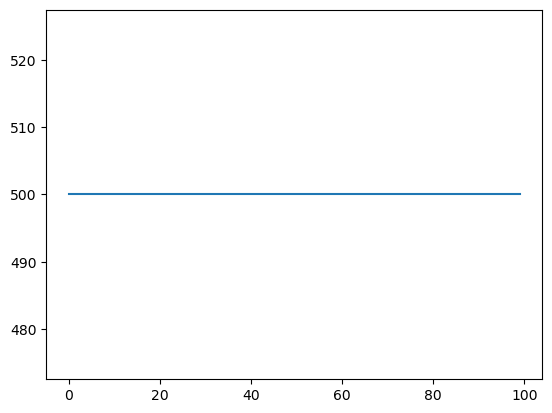

In [51]:
# nv = gym.make('CartPole-v1')
env = gym.make('CartPole-v1', render_mode = 'human')
rewards = []

# net = torch.load('best_target_net.torch')
net= policy_net

loop = tqdm(range(100))
for epoch in loop:
    state, info = env.reset()
    state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)

    total_reward = 0
    for step in count():
        action = select_action(state, 0.0, net, env)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    rewards.append(total_reward)
    
sns.lineplot(y = total_reward, x= list(range(len(rewards))))

# Exp 1

In [ ]:
LR = 5e-4
GAMMA = 0.99
BATCH_SIZE = 32
MEMORY_CAP = 50000
TRAINING_EPOCHS = 2000 
MIN_EP = 0.2
MAX_EP = 1.0
DECAY_EP = 0.9991
C = 10
HIDDEN_SIZE = 16

#===EP_DECAY===
plot_epsilon_decay(MIN_EP, MAX_EP, DECAY_EP, TRAINING_EPOCHS)

#===CONFIG====

env = gym.make('CartPole-v1')
obs, info = env.reset()

observation_n = len(obs)
action_n = env.action_space.n
print('observation space = ', observation_n)
print('action space = ', action_n)

policy_net = DQN(observation_n, action_n, hidden_size = HIDDEN_SIZE)
target_net = DQN(observation_n, action_n, hidden_size = HIDDEN_SIZE)
memory = ReplayMemory(MEMORY_CAP)

optimizer = torch.optim.Adam(policy_net.parameters(), lr = LR)
criterion = nn.MSELoss()

policy_net, target_net, history = tune(
    policy_net, target_net, optimizer, criterion, env, memory,
    gamma = GAMMA, 
    batch_size = BATCH_SIZE, 
    training_epochs= TRAINING_EPOCHS, 
    min_ep = MIN_EP, 
    max_ep = MAX_EP, 
    decay_ep = DECAY_EP, 
    c= C)

plot(history)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(y = history['rewards'], x = list(range(len(history['rewards']))), ax = ax1, color = 'green')
ax1.set_title('rewards')
sns.lineplot(y = history['loss'], x = list(range(len(history['loss']))), ax = ax2)
ax2.set_title('loss')
plt.show()
sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))))
plt.title('epsilon')
plt.show()

# Run the model

In [ ]:
env = gym.make('CartPole-v1')
# env = gym.make('CartPole-v1', render_mode = 'human')
rewards = []

net = torch.load('best_target_net.torch')

loop = tqdm(range(100))
for epoch in loop:
    state, info = env.reset()
    state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)

    total_reward = 0
    for step in count():
        action = select_action(state, 0.0, net, env)
        next_state, reward, terminated, truncated, info = env.step(action.item())
        next_state = torch.tensor(next_state, dtype = torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    loop.set_description(f'ep = {epoch}, reward = {total_reward}')
    rewards.append(total_reward)
    
sns.lineplot(y = total_reward, x= list(range(len(rewards))))


# for epoch in loop:

#     state, info = env.reset() 
#     state = torch.tensor(state, dtype = torch.float32).unsqueeze(0)
#     done = False
#     running_loss = 0
#     total_reward = 0
#     epsilon = epsilon_function(min_ep, max_ep, decay_ep, epoch, 1000)
#     history['epsilon'].append(epsilon)

#     for t in count():
#         with torch.no_grad():
#             action =  select_action(state, 0.1, policy_net, env)
        
#         next_state, reward, terminated, truncated, info = env.step(action.item())
#         total_reward += reward